In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from glob import glob
import cv2 as cv
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, random_rotation
from time import time
from keras import callbacks
import os
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import shutil
from keras.utils import image_dataset_from_directory
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps


In [2]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
      # Random flipping of the image and mask
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
   if tf.random.uniform(()) > 0.5:
      theta = random.randint(0, 359)
      input_image = random_rotation(input_image, theta)
      input_mask = random_rotation(input_mask, theta)
   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [18]:
image_dir = "original_images"
label_dir = "skin_masks"
img_size = (640,640)
batch_size=32

input_img_paths = sorted(
    [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
    ]
)
target_img_paths = sorted(
    [
        os.path.join(label_dir, fname)
        for fname in os.listdir(label_dir)
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

original_images\1_P_hgr1_id01_1.jpg | skin_masks\1_P_hgr1_id01_1.bmp
original_images\1_P_hgr1_id01_2.jpg | skin_masks\1_P_hgr1_id01_2.bmp
original_images\1_P_hgr1_id01_3.jpg | skin_masks\1_P_hgr1_id01_3.bmp
original_images\1_P_hgr1_id02_1.jpg | skin_masks\1_P_hgr1_id02_1.bmp
original_images\1_P_hgr1_id02_2.jpg | skin_masks\1_P_hgr1_id02_2.bmp
original_images\1_P_hgr1_id03_1.jpg | skin_masks\1_P_hgr1_id03_1.bmp
original_images\1_P_hgr1_id03_2.jpg | skin_masks\1_P_hgr1_id03_2.bmp
original_images\1_P_hgr1_id04_1.jpg | skin_masks\1_P_hgr1_id04_1.bmp
original_images\1_P_hgr1_id04_2.jpg | skin_masks\1_P_hgr1_id04_2.bmp
original_images\1_P_hgr1_id05_1.jpg | skin_masks\1_P_hgr1_id05_1.bmp


In [4]:
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10

# Perform the split
train_images, test_images, train_masks, test_masks = train_test_split(input_img_paths, target_img_paths, test_size=test_ratio, random_state=69)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=val_ratio/(train_ratio+val_ratio), random_state=69)

# Create directories for train, val, and test sets
train_dir = 'hand_data/train'
val_dir = 'hand_data/valid'
test_dir = 'hand_data/test'

os.makedirs(train_dir+"/images/hand", exist_ok=True)
os.makedirs(val_dir+"/images/hand", exist_ok=True)
os.makedirs(test_dir+"/images/hand", exist_ok=True)
os.makedirs(train_dir+"/masks/hand", exist_ok=True)
os.makedirs(val_dir+"/masks/hand", exist_ok=True)
os.makedirs(test_dir+"/masks/hand", exist_ok=True)

# Copy files to the corresponding directories
def copy_files(images, masks, destination):
    for image, mask in zip(images, masks):
        shutil.copy(image, destination+"/images/hand")
        shutil.copy(mask, destination+"/masks/hand")

copy_files(train_images, train_masks, train_dir)
copy_files(val_images, val_masks, val_dir)
copy_files(test_images, test_masks, test_dir)

In [20]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
      # Random flipping of the image and mask
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
   if tf.random.uniform(()) > 0.5:
      theta = random.randint(0, 359)
      input_image = random_rotation(input_image, theta)
      input_mask = random_rotation(input_mask, theta)
   return input_image, input_mask

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_datagen.flow_from_directory(
     'hand_data/train/images',
     target_size=img_size,
     batch_size = batch_size,
     shuffle=False)
train_mask_generator = train_datagen.flow_from_directory(
     'hand_data/train/masks',
     target_size=img_size,
     batch_size = batch_size,
     shuffle=False)

val_image_generator = val_datagen.flow_from_directory(
     'hand_data/valid/images',
     target_size=img_size,
     batch_size = batch_size,
     shuffle=False)
val_mask_generator = val_datagen.flow_from_directory(
     'hand_data/valid/masks',
     target_size=img_size,
     batch_size = batch_size,
     shuffle=False)

test_image_generator = test_datagen.flow_from_directory(
     'hand_data/test/images',
     target_size=img_size,
     batch_size = 1,
     shuffle=False)
test_mask_generator = test_datagen.flow_from_directory(
     'hand_data/test/masks',
     target_size=img_size,
     batch_size = 1,
     shuffle=False)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)


Found 674 images belonging to 1 classes.
Found 674 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


In [6]:
len(train_image_generator)

22

In [7]:
import cv2
import numpy as np

# Load an example image
image_path = 'hand_data/test/images/hand/1_P_hgr1_id02_1.jpg'
original_image = cv2.imread(image_path)
mask_path = 'hand_data/test/masks/hand/1_P_hgr1_id02_1.bmp'
original_mask = cv2.imread(mask_path)

# Ensure the image is in the correct shape (height, width, channels)
original_image = original_image.astype(np.float32) / 255.0  # Normalize to [0, 1]
original_mask = original_mask.astype(np.float32) / 255.0  # Normalize to [0, 1]



In [15]:
def rw_obscurity(input_mask, prob=0.01):
    input_mask = np.dot(input_mask, [0.2989, 0.5870, 0.1140])
    zero_indices = np.argwhere(input_mask == 0)
    height, width = input_mask.shape
    start_i = random.randrange(0,zero_indices.shape[0])
    start = zero_indices[start_i,:]
    path = [start]
    direction = 0
    
    dir_dict = {
        'left': np.array([-1,0]),
        'up': np.array([0,1]),
        'right': np.array([1,0]),
        'down': np.array([0,-1])
    }

    while True:
        r = random.uniform(0,1)
        direction_name = list(dir_dict.keys())[direction]
        
        if r < prob:
            direction = (1 + direction) % 4
            direction_name = list(dir_dict.keys())[direction]
        while not (0 <= (path[-1] + dir_dict[direction_name])[0] < height and 0 <= (path[-1] + dir_dict[direction_name])[1] < width):
            direction = (1 + direction) % 4
            direction_name = list(dir_dict.keys())[direction]

        new_point = path[-1] + dir_dict[direction_name]
        if any(np.array_equal(new_point, point) for point in path):
            path.append(new_point)
            break
        path.append(new_point)

    list_path = [item.tolist() for item in path]
    start_loop = list_path.index(list_path[-1])
    path = path[start_loop:]

    return path

In [9]:
path = rw_obscurity(original_mask, prob=0.005)
np.array(map(list,path))

array(<map object at 0x0000021DAC397430>, dtype=object)

In [28]:
import cv2
import numpy as np

# Load an example image
image_path = 'hand_data/test/images/hand/1_P_hgr1_id02_1.jpg'
original_image = cv2.imread(image_path)
mask_path = 'hand_data/test/masks/hand/1_P_hgr1_id02_1.bmp'
original_mask = cv2.imread(mask_path)

path = rw_obscurity(original_image, 0.01)
path_array = np.array(list(map(list, path)), dtype=np.int32)
cv2.fillPoly(original_image, [path_array], color=(255,255,255))
cv2.imshow("",original_image)
cv2.waitKey(0)

-1

In [6]:
path = rw_obscurity(original_mask, prob=0.005)

# Display input image #7
display(Image(filename=train_images[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(train_masks[0], grayscale=True))
display(img)




NameError: name 'rw_obscurity' is not defined

In [7]:
def unet(input_img):

  # First block Going down
  d1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  d1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(d1_2)

  # Second block Going down
  d2_1 = MaxPooling2D()(d1_3)
  d2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_1)
  d2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_2)

  # Third block Going down
  d3_1 = MaxPooling2D()(d2_3)
  d3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_1)
  d3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_2)

  # Fourth block Going down
  d4_1 = MaxPooling2D()(d3_3)
  d4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_1)
  d4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_2)

  # Fifth block 
  d5_1 = MaxPooling2D()(d4_3)
  d5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_1)
  d5_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_2)

  # Fourth block going up, concatenated with Fourth block going down
  up4_0 = UpSampling2D((2, 2))(d5_3)
  up4_1 = tf.keras.layers.concatenate([d4_3, up4_0])
  up4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_1)
  up4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_2)

  # Third block going up, concatenated with Third block going down
  up3_0 = UpSampling2D((2, 2))(up4_3)
  up3_1 = tf.keras.layers.concatenate([d3_3, up3_0])
  up3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_1)
  up3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_2)

  # Second block going up, concatenated with Second block going down
  up2_0 = UpSampling2D((2, 2))(up3_3)
  up2_1 = tf.keras.layers.concatenate([d2_3, up2_0])
  up2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_1)
  up2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_2)

  # First block going up, concatenated with First block going down
  up1_0 = UpSampling2D((2, 2))(up2_3)
  up1_1 = tf.keras.layers.concatenate([d1_3, up1_0])
  up1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_1)
  up1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_2)

  # Output
  out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up1_3)

  return out

In [27]:
input_img = Input(shape=(640, 640, 3))
model = Model(input_img, unet(input_img))

input_img = Input(shape=(640, 640, 3), name='input_img')
input_mask = Input(shape=(640, 640, 1), name='input_mask')

model = Model(inputs=[input_img, input_mask], outputs=unet(input_img))

epochs = 250

model.compile(loss='mean_squared_error', 
              optimizer = optimizers.RMSprop())

es = callbacks.EarlyStopping(patience=25,
                            restore_best_weights=True)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.002**(1+epoch/(epochs*2)))

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="models/best-model.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    initial_value_threshold=0.01)


unet_train = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_image_generator),
    callbacks=[lr_scheduler, es, model_checkpoint])

Epoch 1/250


In [21]:
evaluation = model.evaluate(test_generator, steps=len(test_image_generator))

# Print the evaluation results
print("Test Loss:", evaluation)

90/90 [==============================] - 13s 148ms/step - loss: 0.1036
Test Loss: 0.10357540845870972


In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


In [30]:
model = tf.keras.models.load_model("models/best.model.keras")

1/1 [==============================] - 0s 153ms/step


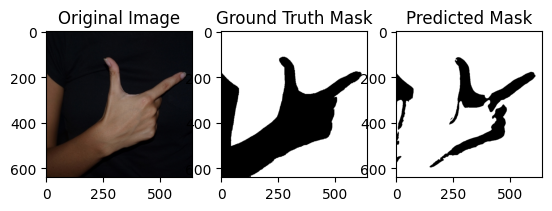

In [26]:
sample_test_batch = next(test_generator)

# Get the model's predictions
predicted_mask = model.predict(sample_test_batch[0])

# Select the first image and its corresponding mask from the batch
sample_test_image = np.resize(sample_test_batch[0][0], (640,640,3))
sample_test_mask = np.resize(sample_test_batch[1][0], (640,640,3))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(sample_test_image)
plt.title('Original Image')

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(sample_test_mask), cmap='gray')
plt.title('Ground Truth Mask')

# Plot the model's predicted mask
thresholded_predicted_mask = (np.squeeze(predicted_mask[0]) >= 0.5).astype(np.uint8)
plt.subplot(1, 3, 3)
plt.imshow(thresholded_predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [82]:
model.save("models/best.model.keras")

In [ ]:
np.squeeze